<a href="https://colab.research.google.com/github/TyaraKusumaNevada/PCVK_Genap_2025/blob/main/Week7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

B. Fungsi Konvolusi Tanpa Library OpenCV

In [3]:
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import math
from google.colab.patches import cv2_imshow
from PIL import Image as im

def convolution2d(image, kernel, stride, padding):
    # Mendapatkan dimensi image dan kernel
    image_height, image_width = image.shape
    kernel_height, kernel_width = kernel.shape

    # Menambahkan padding ke image
    if padding > 0:
        image_padded = np.pad(image, padding, mode='constant', constant_values=0)
    else:
        image_padded = image

    # Menghitung dimensi output
    output_height = (image_height + 2*padding - kernel_height) // stride + 1
    output_width = (image_width + 2*padding - kernel_width) // stride + 1

    # Inisialisasi output
    output = np.zeros((output_height, output_width))

    # Proses konvolusi
    for y in range(0, output_height):
        for x in range(0, output_width):
            # Menghitung area yang akan dikonvolusi
            y_start = y * stride
            y_end = y_start + kernel_height
            x_start = x * stride
            x_end = x_start + kernel_width

            # Ekstrak region dari image
            region = image_padded[y_start:y_end, x_start:x_end]

            # Melakukan konvolusi
            output[y, x] = np.sum(region * kernel)

    return output

Mounted at /content/drive


D. Load Citra dan Konversi ke Grayscale

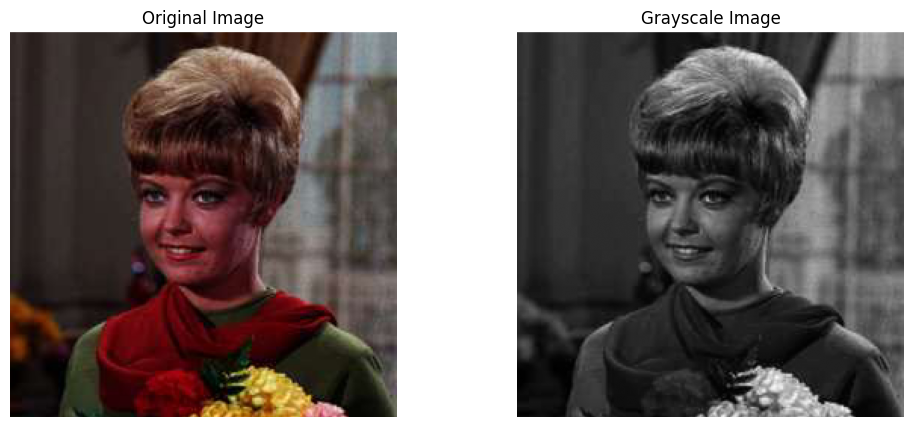

In [4]:
# Load citra dan konversi ke grayscale
img = cv.imread('/content/female.png')
img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

# Menampilkan citra asli dan grayscale
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img_gray, cmap='gray')
plt.title('Grayscale Image')
plt.axis('off')

plt.show()

E. Implementasi Berbagai Filter

In [5]:
# ====== Langkah e: Definisikan kernels ======
import numpy as np
import cv2 as cv
import math

# Average 3x3
kernel_avg_3 = np.ones((3,3), dtype=np.float32)

# Low pass (dalam modul ada contoh 1 1 1 / 1 4 1 / 1 1 1)
kernel_lowpass = np.array([[1,1,1],
                           [1,4,1],
                           [1,1,1]], dtype=np.float32)

# Sharpen (kernel umum)
kernel_sharpen = np.array([[ 0, -1,  0],
                           [-1,  5, -1],
                           [ 0, -1,  0]], dtype=np.float32)

# High-pass (mengikuti contoh di modul; nilai tidak dinormalisasi)
kernel_highpass = np.array([[-1, 0, 1],
                            [-1, 0, 3],
                            [-3, 0, 1]], dtype=np.float32)

# Emboss (sesuai contoh modul)
kernel_emboss = np.array([[-2, -1,  0],
                          [-1,  1,  1],
                          [ 0,  1,  2]], dtype=np.float32)

# Sobel left (deteksi tepi vertikal ke kiri)
kernel_sobel_left = np.array([[ 1, 0, -1],
                              [ 2, 0, -2],
                              [ 1, 0, -1]], dtype=np.float32)

# Prewitt (horizontal/vertical - pakai satu arah saja)
kernel_prewitt_x = np.array([[-1, 0, 1],
                             [-1, 0, 1],
                             [-1, 0, 1]], dtype=np.float32)

# Laplacian-like (modul menuliskan kernel -1 .. 8 .. -1)
kernel_laplacian = np.array([[-1, -1, -1],
                             [-1,  8, -1],
                             [-1, -1, -1]], dtype=np.float32)

# Gaussian 5x5 and 21x21 (generate dengan OpenCV helper)
k5 = 5
sigma5 = math.sqrt(k5)
g1 = cv.getGaussianKernel(k5, sigma5)           # shape (5,1)
kernel_gauss_5 = (g1 @ g1.T).astype(np.float32) # outer product

k21 = 21
sigma21 = math.sqrt(k21)
g2 = cv.getGaussianKernel(k21, sigma21)
kernel_gauss_21 = (g2 @ g2.T).astype(np.float32)


F. Panggil fungsi konvolusi dan tampilkan hasil

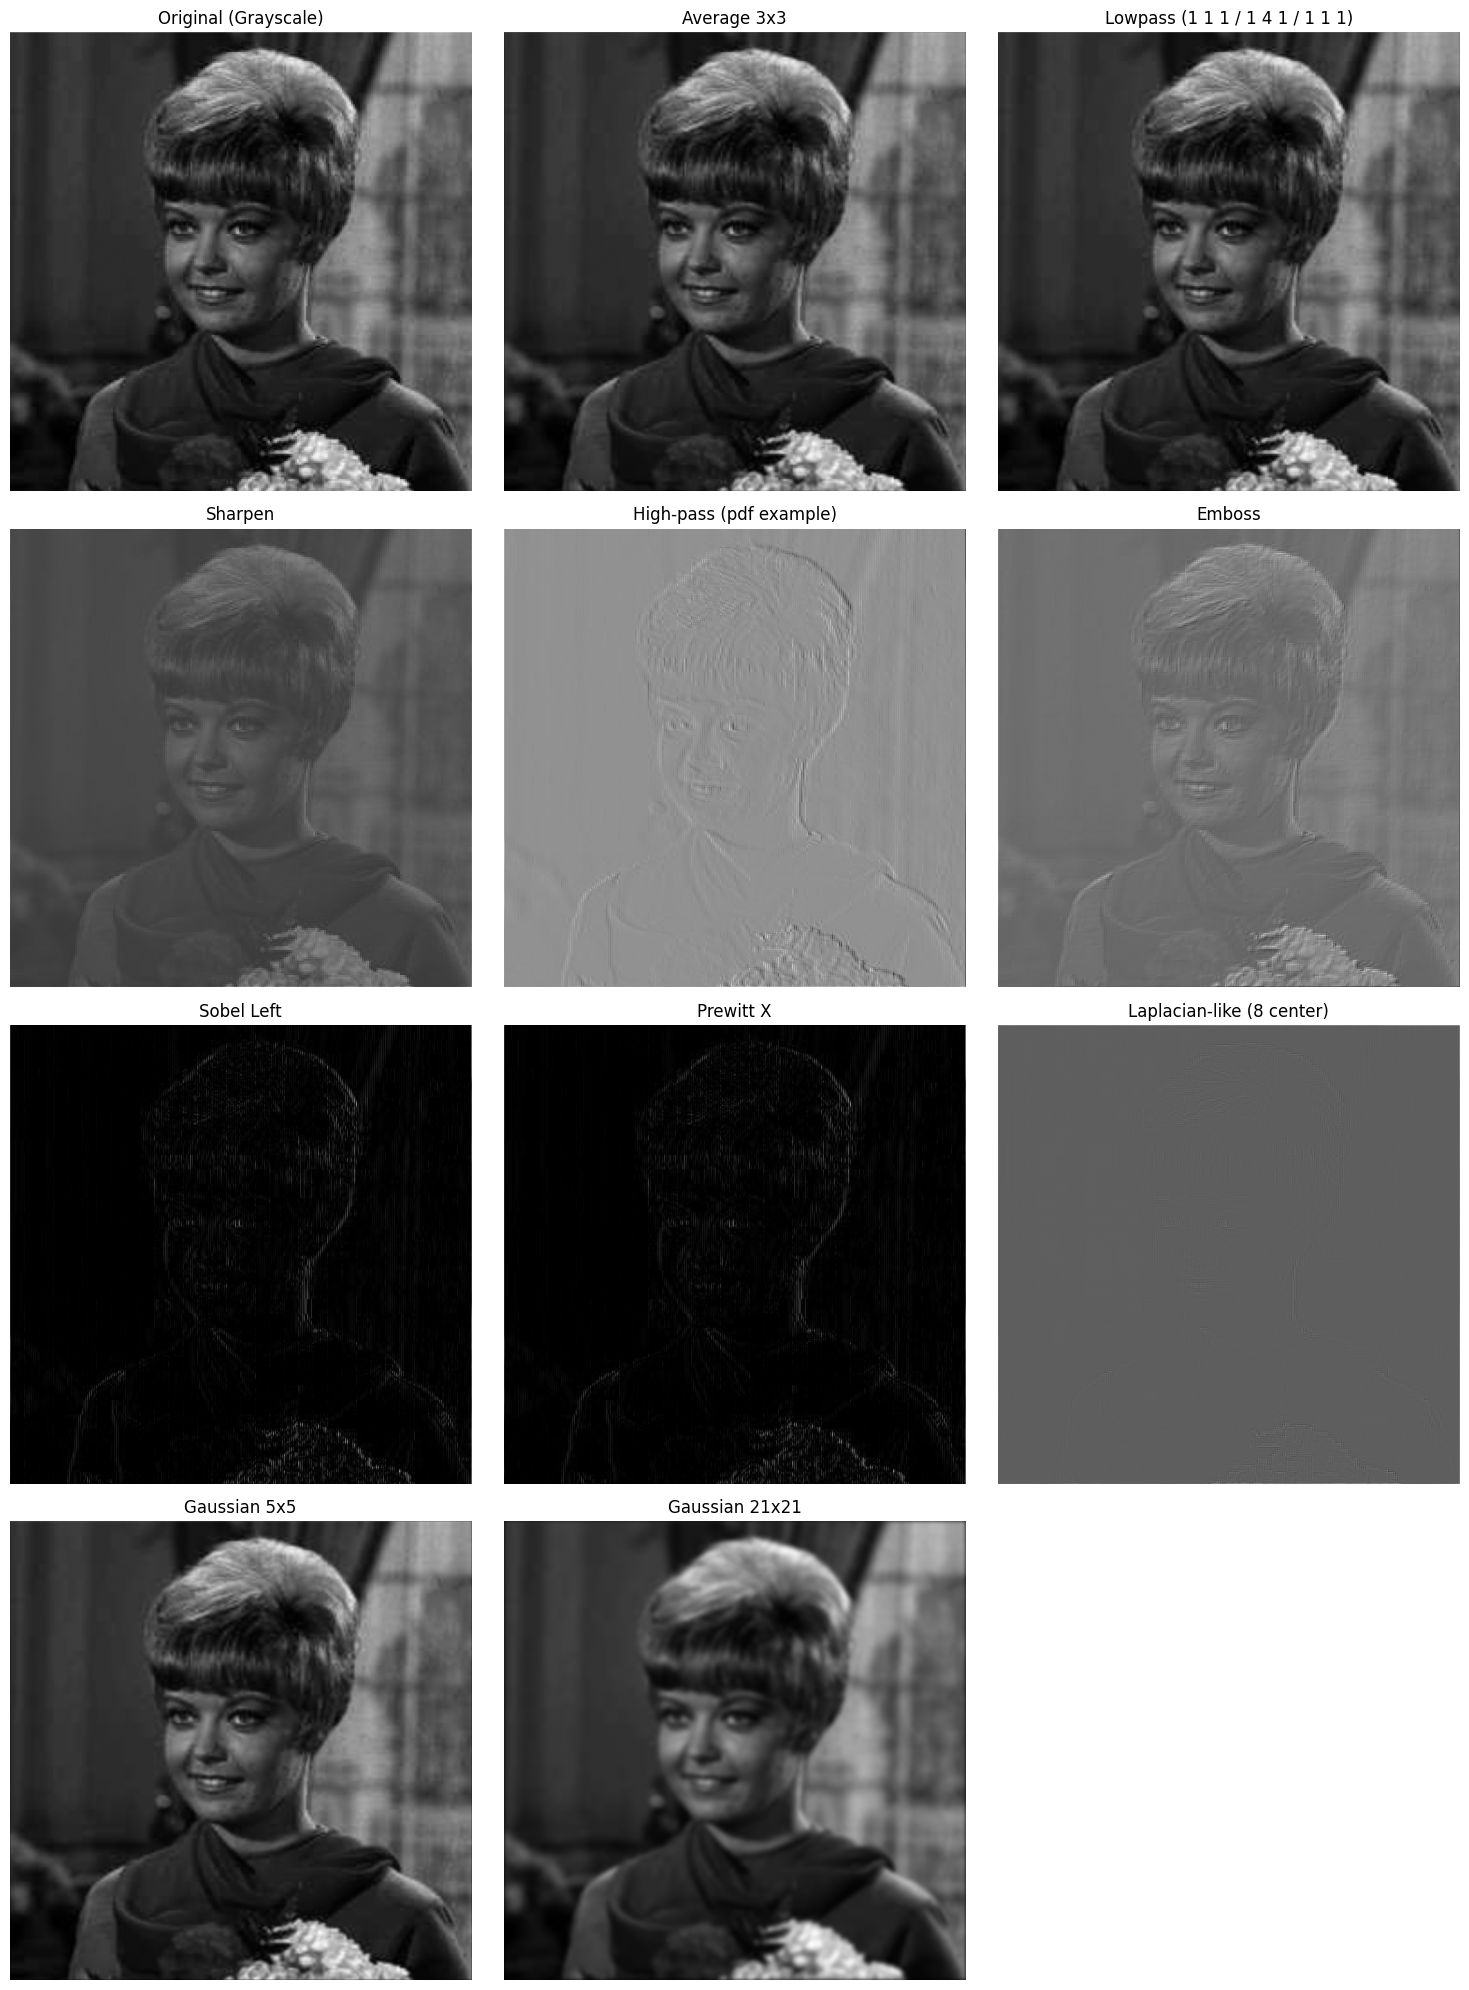

In [7]:
# ====== Langkah f: Helper untuk apply + display hasil ======
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

def apply_filter_and_normalize(image_gray, kernel, *, normalize_kernel=False,
                               display_mode='rescale', add_offset=None):
    """
    image_gray: 2D numpy uint8
    kernel: 2D numpy float
    normalize_kernel: bila True, bagi kernel dengan jumlah elemennya (jika sum!=0)
    display_mode:
        - 'clip' : clip ke [0,255]
        - 'rescale' : min-max rescale ke [0,255]
        - 'abs_norm' : ambil absolute lalu norm ke [0,255] (bagus utk edge)
    add_offset: numeric (mis. 128) untuk menambahkan offset setelah konvolusi (untuk emboss)
    """
    # copy kernel
    k = kernel.astype(np.float32).copy()
    s = k.sum()
    if normalize_kernel and abs(s) > 1e-9:
        k = k / s

    # padding agar ukuran tetap sama
    pad = max(k.shape[0]//2, k.shape[1]//2)
    conv = convolution2d(image_gray.astype(np.float32), k, stride=1, padding=pad)

    if add_offset is not None:
        conv = conv + add_offset

    if display_mode == 'clip':
        out = np.clip(conv, 0, 255)
        out_uint8 = out.astype(np.uint8)
    elif display_mode == 'abs_norm':
        absimg = np.abs(conv)
        if absimg.max() == 0:
            out_uint8 = np.zeros_like(absimg, dtype=np.uint8)
        else:
            out_uint8 = (absimg / absimg.max() * 255).astype(np.uint8)
    elif display_mode == 'rescale':
        mn, mx = conv.min(), conv.max()
        if mx - mn < 1e-9:
            out_uint8 = np.zeros_like(conv, dtype=np.uint8)
        else:
            out_uint8 = ((conv - mn) / (mx - mn) * 255).astype(np.uint8)
    else:
        # fallback: clip
        out_uint8 = np.clip(conv, 0, 255).astype(np.uint8)

    return out_uint8

# Siapkan daftar filter yang akan diterapkan beserta mode tampilannya
filters = [
    ('Average 3x3', kernel_avg_3, True, 'rescale', None),
    ('Lowpass (1 1 1 / 1 4 1 / 1 1 1)', kernel_lowpass, True, 'rescale', None),
    ('Sharpen', kernel_sharpen, False, 'rescale', None),
    ('High-pass (pdf example)', kernel_highpass, False, 'rescale', None),
    ('Emboss', kernel_emboss, False, 'rescale', 128),   # offset +128 supaya hasil berada di [0,255]
    ('Sobel Left', kernel_sobel_left, False, 'abs_norm', None),
    ('Prewitt X', kernel_prewitt_x, False, 'abs_norm', None),
    ('Laplacian-like (8 center)', kernel_laplacian, False, 'rescale', None),
    ('Gaussian 5x5', kernel_gauss_5, False, 'rescale', None),
    ('Gaussian 21x21', kernel_gauss_21, False, 'rescale', None)
]

# Terapkan semua filter dan simpan hasil
results = []
for name, kernel, normalize_flag, disp_mode, offset in filters:
    out = apply_filter_and_normalize(img_gray, kernel, normalize_kernel=normalize_flag,
                                     display_mode=disp_mode, add_offset=offset)
    results.append((name, out))

# Tampilkan original + hasil dalam grid
n = len(results) + 1
cols = 3
rows = math.ceil(n / cols)
plt.figure(figsize=(15, 5*rows))

# Tampilkan gambar asli (grayscale)
plt.subplot(rows, cols, 1)
plt.imshow(img_gray, cmap='gray')
plt.title('Original (Grayscale)')
plt.axis('off')

# Tampilkan hasil filter
for i, (name, out) in enumerate(results, start=2):
    plt.subplot(rows, cols, i)
    plt.imshow(out, cmap='gray')
    plt.title(name)
    plt.axis('off')

plt.tight_layout()
plt.show()


Buat Image Filter untuk Average filter, low pass filter, high pass filter, dan beberapa filter berikut

HASIL BERBAGAI FILTER SPASIAL


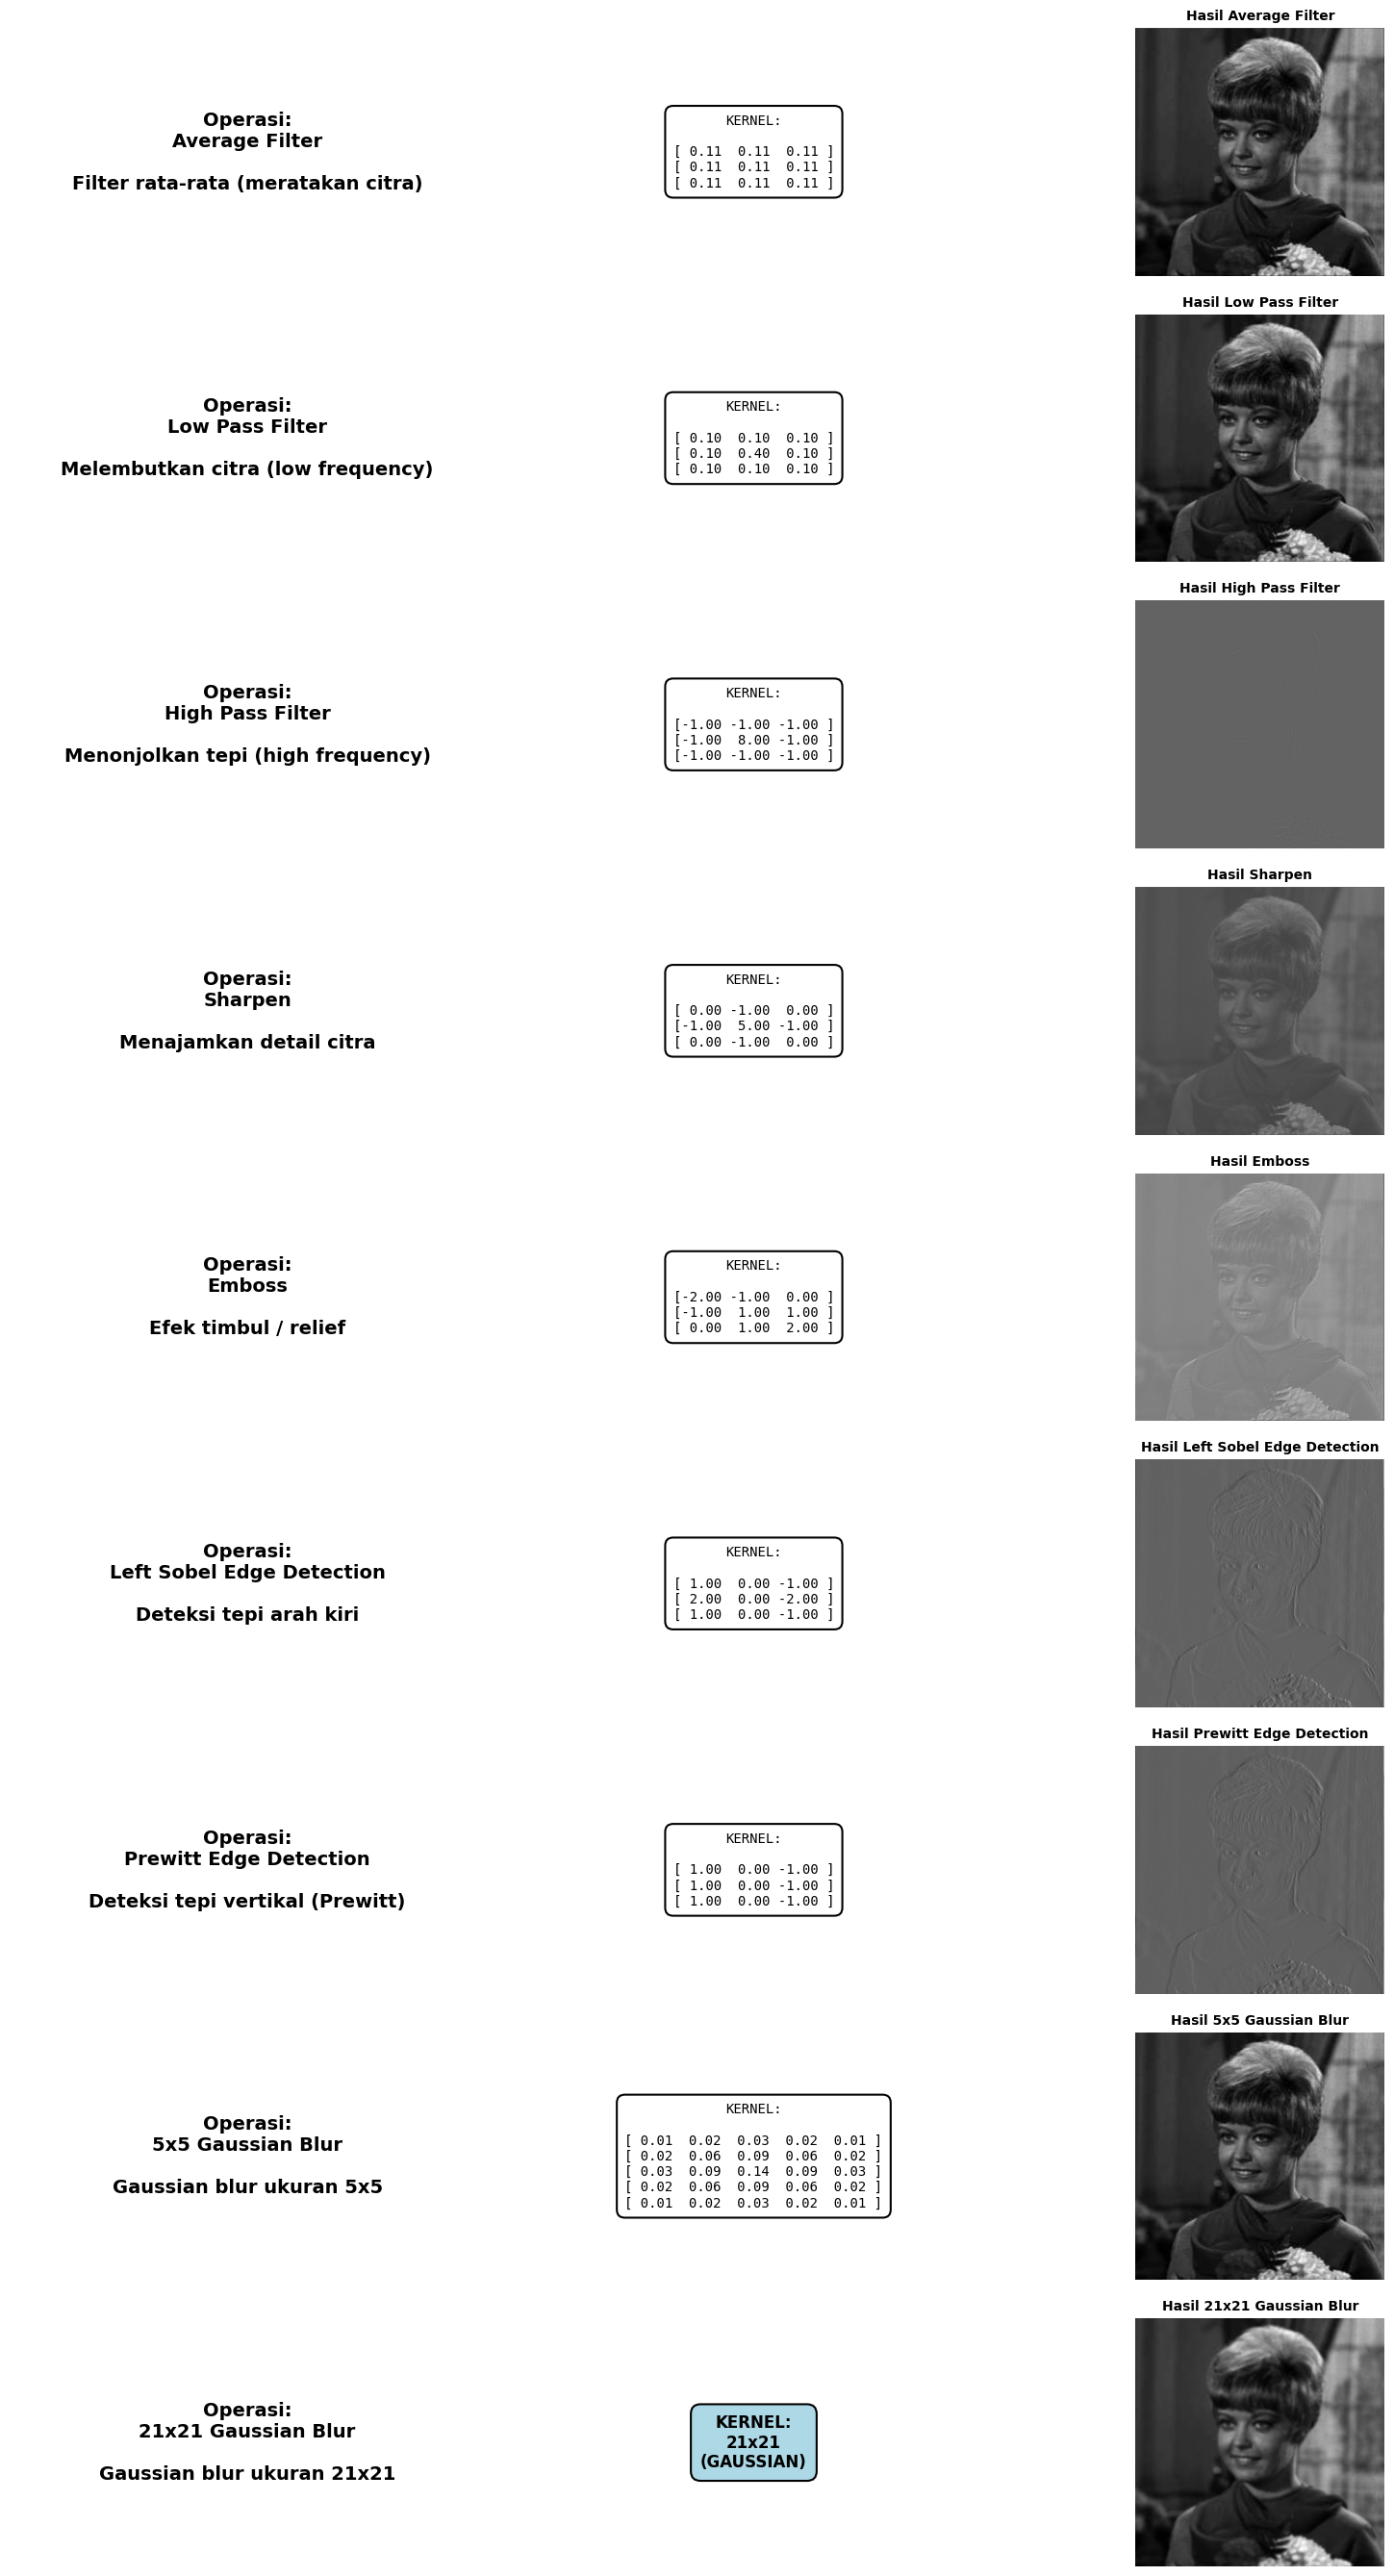

In [9]:
print("HASIL BERBAGAI FILTER SPASIAL")
print("="*80)

num_filters = len(filters)
# Ukuran lebih kecil: tinggi 3 * jumlah filter (bukan 6)
fig = plt.figure(figsize=(16, 3 * num_filters))

for i, (fname, fdata) in enumerate(filters.items()):
    k = fdata['kernel']
    result_img = apply_filter(img_gray, k, stride=1, padding=2)

    # Kolom 1: nama & deskripsi
    ax1 = plt.subplot(num_filters, 3, i*3 + 1)
    ax1.text(0.5, 0.5,
             f"Operasi:\n{fname}\n\n{fdata['description']}",
             ha='center', va='center',
             fontsize=14, fontweight='bold')
    ax1.set_facecolor('#f0f0f0')
    ax1.axis('off')

    # Kolom 2: kernel
    ax2 = plt.subplot(num_filters, 3, i*3 + 2)
    if k.shape[0] <= 5:
        kernel_str = "\n".join(
            ["[" + " ".join(f"{v:5.2f}" for v in row) + " ]" for row in k]
        )
        ax2.text(0.5, 0.5,
                 f"KERNEL:\n\n{kernel_str}",
                 ha='center', va='center',
                 fontsize=10, family='monospace',
                 bbox=dict(boxstyle="round,pad=0.6",
                           facecolor="white", edgecolor="black", lw=1.5))
    else:
        ax2.text(0.5, 0.5,
                 f"KERNEL:\n{ k.shape[0] }x{ k.shape[1] }\n(GAUSSIAN)",
                 ha='center', va='center',
                 fontsize=12, fontweight='bold',
                 bbox=dict(boxstyle="round,pad=0.6",
                           facecolor="lightblue", edgecolor="black", lw=1.5))
    ax2.set_facecolor('#f0f8f0')
    ax2.axis('off')

    # Kolom 3: hasil
    ax3 = plt.subplot(num_filters, 3, i*3 + 3)
    ax3.imshow(result_img, cmap='gray')
    ax3.set_title(f"Hasil {fname}",
                  fontsize=10, fontweight='bold')
    ax3.axis('off')

# Lebih rapat antar subplot
plt.tight_layout(pad=1.5)
plt.show()


CETAK DETAIL KERNEL UNTUK FILTER BERUKURAN KECIL

In [10]:
print("\nDetail Kernel untuk Filter Berukuran kecil")
print("=" * 60)

for name, fdata in filters.items():
    k = fdata['kernel']
    if k.shape[0] <= 5:
        print(f"\n{name}:")
        print(k)


Detail Kernel untuk Filter Berukuran kecil

Average Filter:
[[0.11111111 0.11111111 0.11111111]
 [0.11111111 0.11111111 0.11111111]
 [0.11111111 0.11111111 0.11111111]]

Low Pass Filter:
[[0.1 0.1 0.1]
 [0.1 0.4 0.1]
 [0.1 0.1 0.1]]

High Pass Filter:
[[-1 -1 -1]
 [-1  8 -1]
 [-1 -1 -1]]

Sharpen:
[[ 0 -1  0]
 [-1  5 -1]
 [ 0 -1  0]]

Emboss:
[[-2 -1  0]
 [-1  1  1]
 [ 0  1  2]]

Left Sobel Edge Detection:
[[ 1  0 -1]
 [ 2  0 -2]
 [ 1  0 -1]]

Prewitt Edge Detection:
[[ 1  0 -1]
 [ 1  0 -1]
 [ 1  0 -1]]

5x5 Gaussian Blur:
[[0.00500788 0.01729958 0.02615146 0.01729958 0.00500788]
 [0.01729958 0.05976089 0.09033947 0.05976089 0.01729958]
 [0.02615146 0.09033947 0.13656459 0.09033947 0.02615146]
 [0.01729958 0.05976089 0.09033947 0.05976089 0.01729958]
 [0.00500788 0.01729958 0.02615146 0.01729958 0.00500788]]
